link to data: https://drive.google.com/file/d/14FdevY2Gxdyt2eI8amPYP_I3aTmIu5l1/view?usp=sharing

# 0. Imports


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models  import Sequential
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras import callbacks
import pickle

In [2]:
!pip install split_folders

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import zipfile
import os
import enum

import splitfolders

## 0.1 Mounting Drive


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# data zip
!ls gdrive/MyDrive/ENEL645/

Data  modules  Notebooks


In [8]:
# unzip data and add to /temp dir
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ENEL645/Data/Data.zip', 'r')
zip_ref.extractall('/temp')
zip_ref.close()

In [9]:
# sub directories in data zip
print(os.listdir('/temp/Data/'))

['.DS_Store', 'Full', 'OurData', 'Prof_Kaggle', 'ProfsData', 'KaggleData']


In [10]:
our_data_path = '/temp/Data/OurData'
full_data_path = '/temp/Data/Full'
kaggle_data_path = '/temp/Data/KaggleData'
prof_kaggle_data_path = '/temp/Data/Prof_Kaggle'
enel_data_path = '/temp/Data/ProfsData'

path = '/train_val_test'

In [ ]:
#import shutil
#shutil.rmtree('/temp/Data/ProfsData/train_val_test')

## 0.2 Functions

In [11]:
# function to train test split data in data_path to output_name directories
def train_val_test_split(data_path, output_name, train_per, test_per, val_per):
  splitfolders.ratio(data_path, output=output_name,
    seed=123, ratio=(train_per, test_per, val_per), group_prefix=None, move=False)

In [12]:
# function to count files in specified directory
def count_files(item_dir):
  return len(os.listdir(item_dir))

In [13]:
# deletes files from specified directory
def delete_files(path):
  import shutil
  shutil.rmtree(path)

In [ ]:
#delete_files('/checkpoints/vgg16')

# Part 0: Models

In [15]:
# CNN architecture without dropout, plust each more max pooling
def CNN(image_shape=(224,224,3), k = 3, lr = 1e-4):
  model_input = tf.keras.layers.Input(shape = image_shape)
  l1 = tf.keras.layers.Conv2D(24, (3,3), padding='same', activation='relu')(model_input)
  l1_max = tf.keras.layers.MaxPool2D((2,2))(l1)
  l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1_max)
  l2_max = tf.keras.layers.MaxPool2D((2,2))(l2)
  l3 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l2_max)
  l3_max = tf.keras.layers.MaxPool2D((2,2))(l3)
  l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3_max)

  flat = tf.keras.layers.Flatten()(l4)
  out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
  model = tf.keras.models.Model(inputs = model_input, outputs = out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

# Part 1: Test Models on Same Data

## 1. Inspect the Data

### 1.1 Data Distribution

No handles with labels found to put in legend.


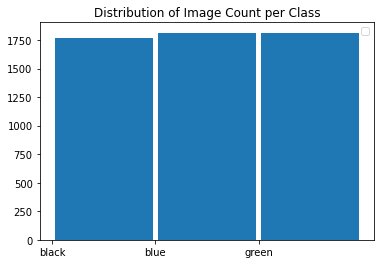

In [16]:
black_bin_count = count_files(enel_data_path + '/Black')
blue_bin_count = count_files(enel_data_path + '/Blue')
green_bin_count = count_files(enel_data_path + '/Green')
data = [black_bin_count, blue_bin_count, green_bin_count]

plt.hist(['black', 'blue', 'green'], weights=data, bins=range(4), rwidth=.95)
plt.legend()
plt.title('Distribution of Image Count per Class')
plt.show()

### 1.2 Sample of Data

In [17]:
def plot_images (item_dir, first=10):
  all_item_names = os.listdir(item_dir)
  item_paths = [os.path.join(item_dir,file) for file in all_item_names][:5]
  print(item_paths)

  #configure fig size
  plt.figure(figsize=(10,10))
  for index, image_path in enumerate(item_paths):
    plt.subplot(5,5,index+1)
    img = plt.imread(image_path)
    plt.tight_layout()
    plt.imshow(img,cmap='gray')

['/temp/Data/ProfsData/Black/blackProf_948.png', '/temp/Data/ProfsData/Black/blackProf_462.png', '/temp/Data/ProfsData/Black/blackProf_630.png', '/temp/Data/ProfsData/Black/blackProf_420.png', '/temp/Data/ProfsData/Black/blackProf_5.png']
['/temp/Data/ProfsData/Blue/blueProf_821.png', '/temp/Data/ProfsData/Blue/blueProf_934.png', '/temp/Data/ProfsData/Blue/blueProf_1780.png', '/temp/Data/ProfsData/Blue/blueProf_1596.png', '/temp/Data/ProfsData/Blue/blueProf_1260.png']
['/temp/Data/ProfsData/Green/greenProf_863.png', '/temp/Data/ProfsData/Green/greenProf_591.png', '/temp/Data/ProfsData/Green/greenProf_620.png', '/temp/Data/ProfsData/Green/greenProf_1446.png', '/temp/Data/ProfsData/Green/greenProf_552.png']


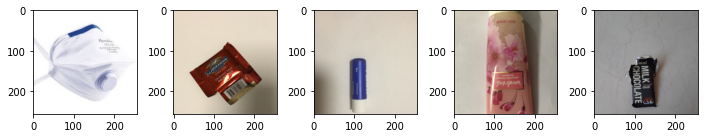

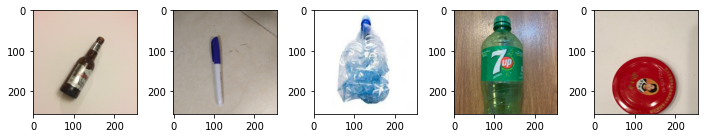

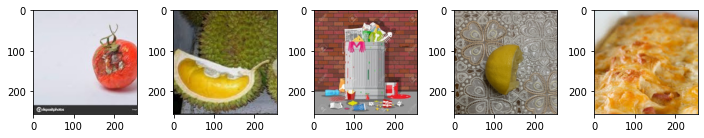

In [23]:
plot_images(enel_data_path + '/Black')
plot_images(enel_data_path + '/Blue')
plot_images(enel_data_path + '/Green')

## 2. Train Test Split

In [24]:
## Train Validation Test Split
train_val_test_split(enel_data_path, '/train_val_test/ProfsData', 0.7, 0.2, 0.1)

Copying files: 5391 files [00:01, 3433.55 files/s]


## 4. Image Augmentation and Data Generators


In [25]:
#TESTED: tested with vgg16, worked as expected
def create_generators(model_name,data_path,params_index=0,batch_size=64,seed=88):

  if model_name == 'none':
    preprocessing_function=None,
    image_size=(224,224)
  elif model_name=="efficientnetb0":
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    image_size=(224,224)
  elif model_name=="vgg16":
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    image_size=(224,224)
  elif model_name=="resnet50":
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    image_size=(224,224)

  #classes
  class_names = ["Black", "Blue",  "Green"]

  #params
  params_0 = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

  params_1 = {"horizontal_flip":True,\
              "vertical_flip":True,\
             'fill_mode': 'nearest',\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
             "brightness_range":[0.9,1.1],\
             }

  params_2 = {"horizontal_flip":False,\
              "vertical_flip":False,
             }

  params_list=[params_0, params_1, params_2]           
  params=params_list[params_index]

  #image augmentation
  # image_augmentation = ImageDataGenerator(horizontal_flip=True, 
  #                        vertical_flip=True,
  #                        width_shift_range = 0.1,
  #                        height_shift_range=0.1,
  #                        rotation_range=15,
  #                        fill_mode='nearest',
  #                        brightness_range=[0.75,1.25],
  #                        zoom_range=0.25,
  #                        rescale=1.0/255,
  #                        preprocessing_function=preprocessing_function
  #                        )

  image_augmentation = ImageDataGenerator(**params,preprocessing_function=preprocessing_function)

  #generators
  train_generator = image_augmentation.flow_from_directory(data_path+'/train',
                                                           batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            classes=class_names,
                                            shuffle=True,
                                            seed=seed,
                                            color_mode="rgb")

  validation_generator = image_augmentation.flow_from_directory(data_path+'/val',
                                                                batch_size=batch_size,
                                              target_size=image_size,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=seed,
                                              color_mode="rgb"
                                              )

  test_generator = image_augmentation.flow_from_directory(data_path+'/test',
                                            batch_size=batch_size,
                                              target_size=image_size,
                                              class_mode='categorical',
                                            classes=class_names,
                                              shuffle=True,
                                              seed=seed,
                                            color_mode="rgb"
                                            )
  
  #step sizes
  step_size_train=train_generator.n//train_generator.batch_size
  step_size_validation =validation_generator.n//validation_generator.batch_size
  step_size_test =test_generator.n//test_generator.batch_size

  #return [(generator tuple),(size tuple)]
  return [(train_generator,validation_generator,test_generator),
          (step_size_train,step_size_validation,step_size_test)]

## 5. Callbacks

In [26]:
def create_callbacks(model_name,patientce=5,epochs=30,lr=1e-6):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = patientce)

  def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

  #set verbose = 0, nothing will be shown
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

  #Note: cannot save to h5 files, there will be errors, have to use directory
  path_model_it = '/checkpoints/'+model_name+'_it/'
  path_model_ft = '/checkpoints/'+model_name+'_ft/'


  monitor_it = tf.keras.callbacks.ModelCheckpoint(filepath=path_model_it, 
                                                  monitor='val_loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min')

  monitor_ft = tf.keras.callbacks.ModelCheckpoint(filepath=path_model_ft, 
                                                  monitor='val_loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min')

  return (early_stop,lr_schedule, monitor_it, monitor_ft, path_model_it, path_model_ft)


## 6. Plot methods

### Plot History: train and validation

In [41]:
def plot_history(history_object, model_name = None, dataset_name = None):
  fig,axes=plt.subplots(1,2, figsize=(10,5))
  ax_accuracy = axes[0]
  ax_loss = axes[1]
  ax_accuracy.plot(history_object.history['accuracy'])
  ax_accuracy.plot(history_object.history['val_accuracy'])
  ax_accuracy.set_title('Accuracy Plot')
  ax_accuracy.legend(['Train', 'Validation'], loc='upper left')
  ax_accuracy.set(xlabel='Epochs',ylabel='Accuracy')
  ax_loss.plot(history_object.history['loss'])
  ax_loss.plot(history_object.history['val_loss'])
  ax_loss.set_title('Loss Plot')
  ax_loss.legend(['Train', 'Validation'], loc='upper right')
  ax_loss.set(xlabel='Epochs',ylabel='loss')
  
  title = 'Accuracy & Loss Plots'
  if model_name != None:
    title =  title + " of " + model_name 
    if dataset_name != None:
      title = title + ' (' + dataset_name+')'

  fig.suptitle(title, fontsize=16)
  plt.subplots_adjust(left = 0.01)

  plt.show()
  return {
      'fig':fig,
      'axes':axes
  }

### Plot Wrong Predictions

In [36]:
# References: ENEL645 transfer_learning_imagenet
def plot_wrong_predictions(model,test_generator):
  Xtest,Ytest = test_generator.__getitem__(0)
  Ytest = Ytest.argmax(axis = 1) # get the label
  Ypred = model.predict(Xtest).argmax(axis = 1)
  wrong_indexes = np.where(Ypred != Ytest)[0]

  # Disaplying some samples from the development set
  class_names = ["Black", "Blue",  "Green"]
  sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
  plt.figure(figsize = (24,18))
  for (ii,jj) in enumerate(sample_indexes):
      plt.subplot(4,2,ii+1)
      aux = Xtest[wrong_indexes[jj]]
      aux = (aux - aux.min())/(aux.max() - aux.min())
      plt.imshow(aux, cmap = "gray")
      plt.title("Label: %s vs. Predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
  plt.show()

## 6. None Transfer Learning Process

In [44]:
def none_transfer_learning(model_name,data_path,params_index=0,epochs=30,lr=1e-4):
  model = None

  class_names = ["Black", "Blue",  "Green"]

  #choose model
  #References: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0
  #References: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
  if(model_name=="none"):
    return "Invalid model"
  elif(model_name=="efficientnetb0"):
    model = tf.keras.applications.EfficientNetB0(classes = len(class_names),
                                                 include_top=True,
                                        weights=None)
    model.trainable=True;
  elif(model_name=="vgg16"):
    model = tf.keras.applications.VGG16(classes = len(class_names),
                                        include_top=True,
                                        weights=None)
    model.trainable=True
  elif(model_name=="resnet50"):
    model = tf.keras.applications.ResNet50(classes = len(class_names),
                                        include_top=True,
                                        weights=None)
    model.trainable=True
    
  generators = create_generators(model_name,data_path)
  callbacks=create_callbacks(model_name)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  history = model.fit(generators[0][0], 
                         epochs=epochs, 
                         verbose = 1, 
                       callbacks= [callbacks[0],callbacks[1]], 
                       validation_data = generators[0][1])
  
  test_score = model.evaluate(generators[0][2])  

  return {
      "model":model,
      "model_name":model_name,
      "epochs":epochs,
      "lr":lr,
      "history":history,
      "test_score":test_score,
      "generators": generators,
      "callbacks": callbacks
  }

## 6. Transfer Learning Processes - All In One

In [49]:
def transfer_learning(model_name,data_path,params_index=0,epochs=30,lr=1e-4):
  base_model = None

  #choose model
  if(model_name=="none"):
    return "Invalid model"
  elif(model_name=="efficientnetb0"):
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',  # Load base model with ImageNet weights
        input_shape=(224, 224, 3),
        include_top=False)
  elif(model_name=="vgg16"):
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',  # Load base model with ImageNet weights
        input_shape=(224, 224, 3),
        include_top=False)
    
  #classes
  class_names = ["Black", "Blue",  "Green"]

  #disable training
  base_model.trainable=False

  #Adding layers
  l1 = base_model(base_model.input, training = False)
  l2 = tf.keras.layers.Flatten()(l1)

  out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(l2)
  model = tf.keras.Model(inputs = base_model.input, outputs = out)

  #complie model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  #create data generators
  generators = create_generators(model_name,data_path)

  #create callbacks
  callbacks = create_callbacks(model_name,5,epochs)

  #intial train model
  history_it = model.fit(generators[0][0], #train generator
                         epochs=epochs-5, #hard coded to be 5
                         verbose = 1, 
                       callbacks= [callbacks[0],callbacks[1],callbacks[2]], 
                       validation_data = generators[0][1])
  
  #fine tuning
  print("#1")
  model = tf.keras.models.load_model(callbacks[4])
  model.trainable = True

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history_ft = model.fit(generators[0][0], 
                         epochs=epochs-10, 
                         verbose = 1, 
                       callbacks= [callbacks[0],callbacks[1],callbacks[3]], 
                       validation_data = generators[0][1])

  model = tf.keras.models.load_model(callbacks[4])
  score_it = model.evaluate(generators[0][2])

  model = tf.keras.models.load_model(callbacks[5])
  score_ft = model.evaluate(generators[0][2])

  #return (history_it,history_ft,score_it,score_ft)
  return {
      'history_it':history_it,
      'history_ft':history_ft,
      'score_it': score_it,
      'score_ft':score_ft,
      'model':model,
      'model_name':model_name,
      'generators':generators,
      'callbacks':callbacks
  }



## VGG16 - None Transfer Learning

## VGG16 - Transfer Learning

## EfficientNet - Transfer Learning

In [51]:
efficientnetb0_tl = []

for params_index in range(3):
  efficientnetb0_tl.append(transfer_learning('efficientnetb0','/train_val_test/ProfsData',params_index,15))

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
Epoch 1/10
59/59 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.7285
Epoch 1: val_loss improved from inf to 0.50543, saving model to /checkpoints/efficientnetb0_it/
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
59/59 [==============================] - 118s 2s/step - loss: 0.6763 - accuracy: 0.7285 - val_loss: 0.5054 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 2/10
59/59 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.8150
Epoch 2: val_loss improved from 0.50543 to 0.47726, saving model to /checkpoints/efficientnetb0_it/
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
59/59 [==============================] - 94s 2s/step - loss: 0.4625 - accuracy: 0.8150 - val_loss: 0.4773 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 3/10
59/59 [==============================] - 

In [54]:
augmentation_names = ['Profs Augmentation','Our Augmentation','No Augmentation']

In [60]:
for results,aug in zip(efficientnetb0_tl,augmentation_names):
  print('Model: ',results.get('model_name'),", Augmentation: ", aug, " , Test loss: ",results.get('score_ft')[0]," , Test Accuacy: ", results.get('score_ft')[1])

Model:  efficientnetb0 , Augmentation:  Profs Augmentation  , Test loss:  0.501871645450592  , Test Accuacy:  0.8044280409812927
Model:  efficientnetb0 , Augmentation:  Our Augmentation  , Test loss:  0.5408719182014465  , Test Accuacy:  0.8118081092834473
Model:  efficientnetb0 , Augmentation:  No Augmentation  , Test loss:  0.5633201599121094  , Test Accuacy:  0.7952029705047607


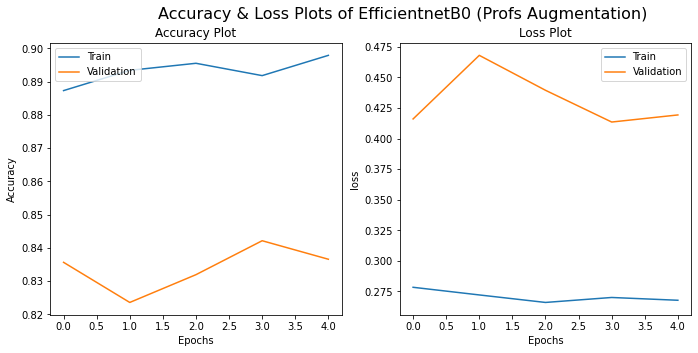

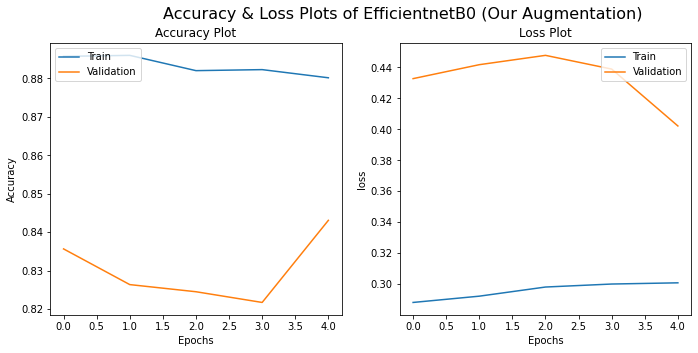

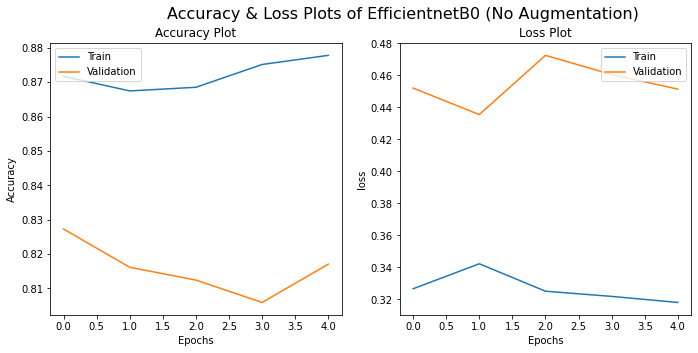

In [56]:
for results, aug in zip(efficientnetb0_tl,augmentation_names):
  plot_history(results.get('history_ft'),'EfficientnetB0', aug)

TRANSFER LEARNING:  efficientnetb0(Profs Augmentation)


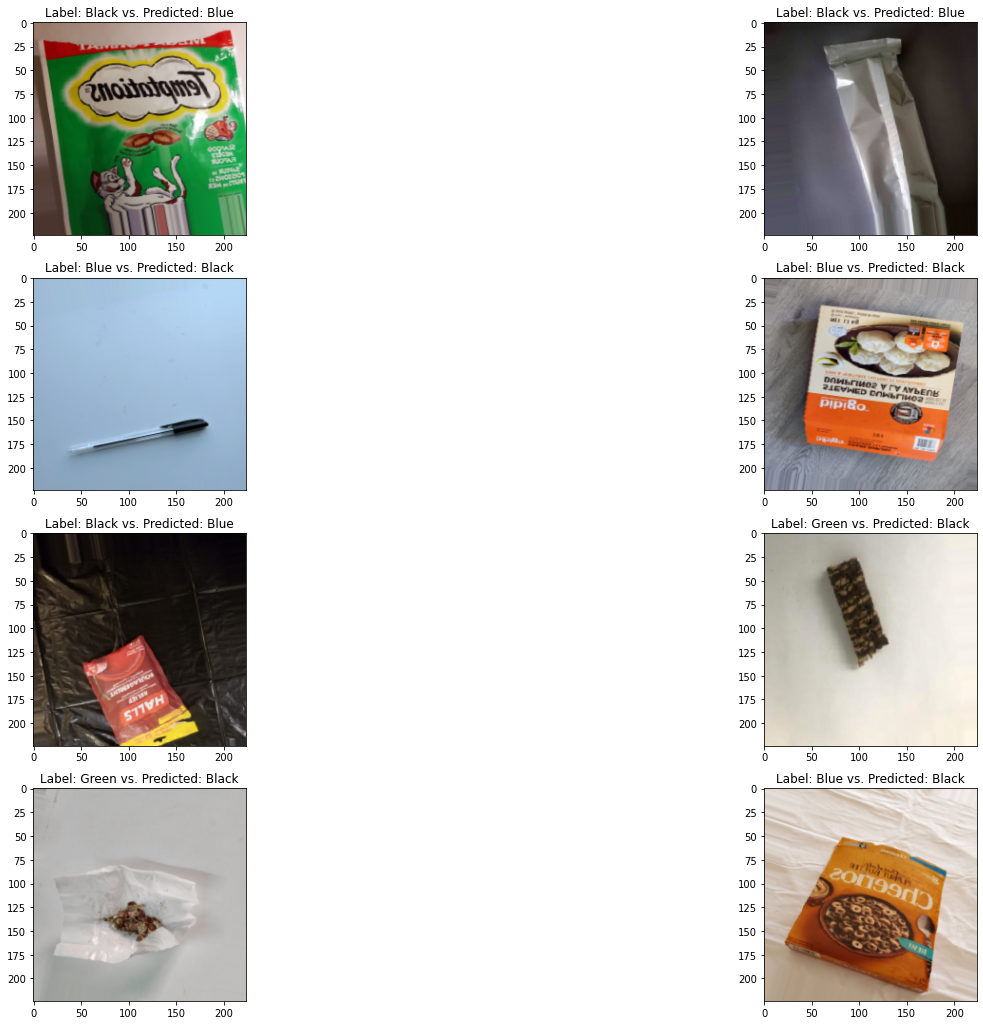

TRANSFER LEARNING:  efficientnetb0(Our Augmentation)


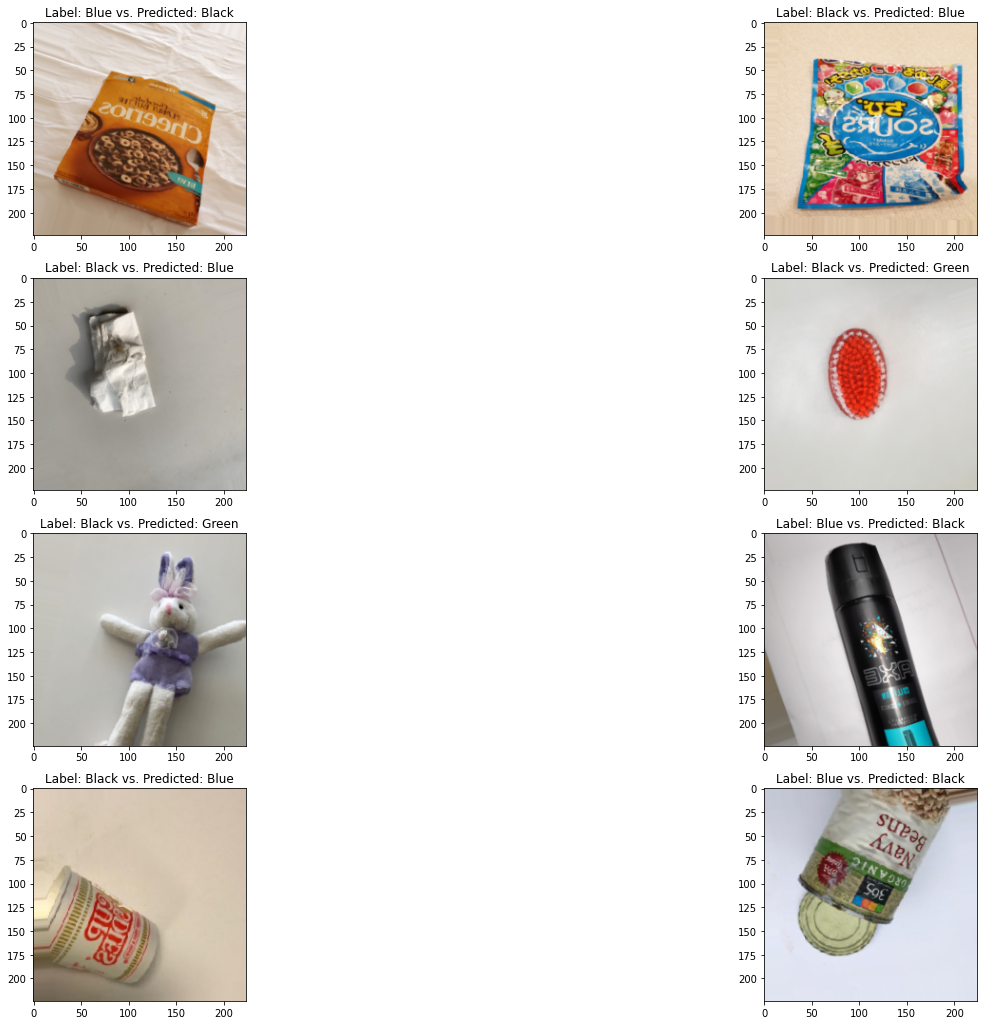

TRANSFER LEARNING:  efficientnetb0(No Augmentation)


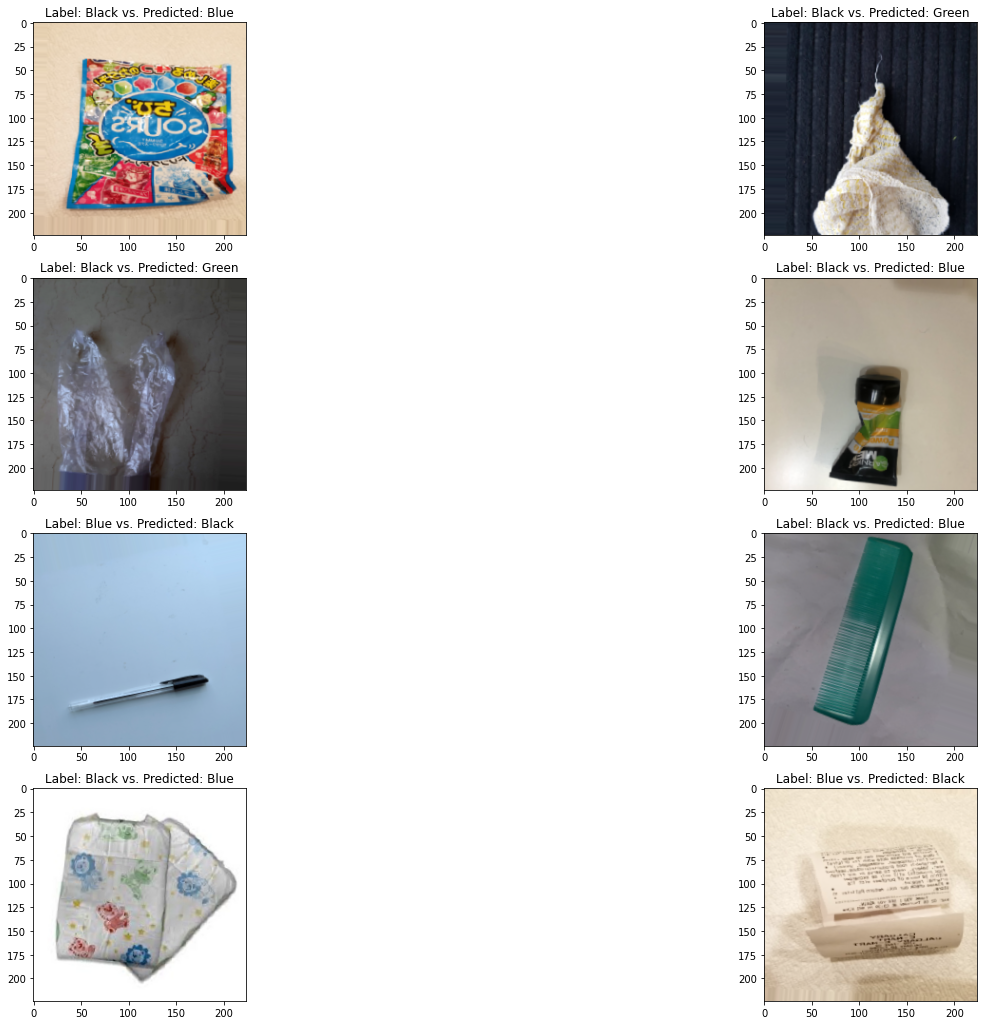

In [59]:
for results, aug in zip(efficientnetb0_tl,augmentation_names):
  print("TRANSFER LEARNING: ", results.get('model_name') + '('+ aug + ')')
  plot_wrong_predictions(results.get('model'),results.get('generators')[0][2])

## EfficientNetB0 - None Transfer Learning